In [ ]:
#import image stored in data[0]
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import skimage.io
#im= np.fromfile('im.dat', dtype='float32')
#im.shape
#im

In [ ]:
filename = "tomo_00031.h5"
with h5py.File(filename, 'r') as file:
    # Access and read data from the file
    dataset = file['exchange/data']
    data = dataset[:]

Text(0.5, 1.0, 'Original Image (data[0])')

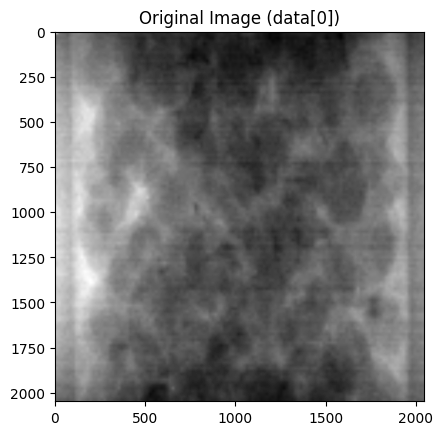

In [ ]:
from skimage.transform import resize

im =  data[0].astype('float32')
im = resize(im[:,:], (130,130))
im=resize(im[:,:], (2048, 2048))
plt.imshow(im, cmap='gray')
plt.title('Original Image (data[0])')

In [ ]:
im

array([[5.8557506, 5.9440947, 6.0324383, ..., 4.1289577, 4.1238   ,
        4.1186414],
       [5.9568324, 6.055616 , 6.1544   , ..., 4.1442046, 4.1382546,
        4.1323047],
       [6.057914 , 6.1671376, 6.2763615, ..., 4.159451 , 4.1527095,
        4.145968 ],
       ...,
       [4.704445 , 4.7150874, 4.72573  , ..., 4.65791  , 4.652182 ,
        4.646455 ],
       [4.7215447, 4.7311506, 4.740756 , ..., 4.669225 , 4.663833 ,
        4.658441 ],
       [4.7386446, 4.7472134, 4.7557826, ..., 4.6805406, 4.6754837,
        4.6704273]], dtype=float32)

### Apply TomoGan denoising:

In [ ]:
import tensorflow as tf
import numpy as np
import sys, time, imageio, h5py, skimage, glob, os, shutil

In [ ]:
TomoGAN_mdl = tf.keras.models.load_model('TomoGAN.h5', )
TomoGAN_mdl.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 8)        16        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 32)       2336      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, None, None, 32)       9248      ['conv2d_1[0][0]']            
                                                                                              

In [ ]:
noised=np.array([im])
noised.shape

(1, 2048, 2048)

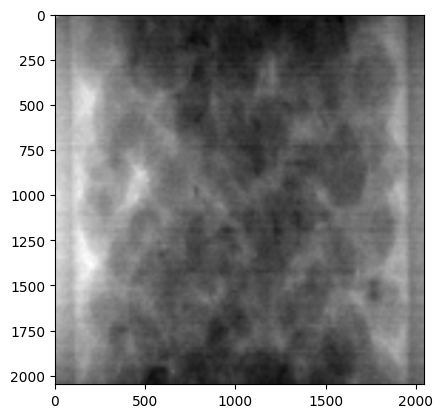

In [ ]:
plt.imshow(im, cmap='gray')

1/1 [==============================] - 32s 32s/step


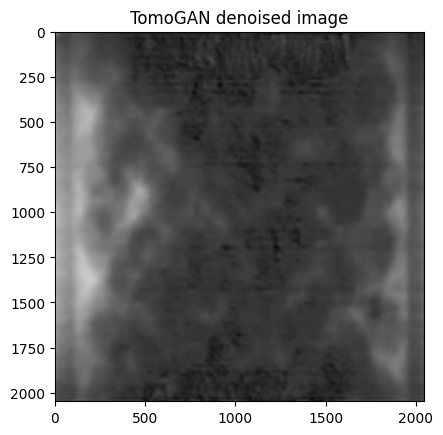

In [ ]:
for _idx in range(noised.shape[0]):
    dn_img_tomo = TomoGAN_mdl.predict(noised[_idx:_idx+1,:,:,np.newaxis]).squeeze()
    plt.imshow(dn_img_tomo, cmap='gray')
    plt.title('TomoGAN denoised image')

### Applying CNN:

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import sys, time, imageio, h5py, skimage, os, shutil
from tensorflow.keras.layers import Conv2D, Input
from skimage.transform import resize


In [ ]:
# overwrite anyway
if os.path.isdir('dataset'):
    shutil.rmtree('dataset')
os.mkdir('dataset') # to save temp output

!wget -O dataset/demo-dataset.h5 https://raw.githubusercontent.com/AIScienceTutorial/Denoising/main/dataset/demo-dataset.h5

--2023-09-10 17:49:11--  https://raw.githubusercontent.com/AIScienceTutorial/Denoising/main/dataset/demo-dataset.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71307264 (68M) [application/octet-stream]
Saving to: ‘dataset/demo-dataset.h5’

dataset/demo-datase 100%[===================>]  68.00M   193MB/s    in 0.4s    

2023-09-10 17:49:13 (193 MB/s) - ‘dataset/demo-dataset.h5’ saved [71307264/71307264]



In [ ]:
with h5py.File('dataset/demo-dataset.h5', 'r') as h5fd:
    ns_img_train = h5fd['train_ns'][:]
    gt_img_train = h5fd['train_gt'][:]

    ns_img_test = h5fd['test_ns'][:]
    gt_img_test = h5fd['test_gt'][:]

ns_img_train.shape, gt_img_train.shape, ns_img_test.shape, gt_img_test.shape

((512, 128, 128), (512, 128, 128), (32, 128, 128), (32, 128, 128))

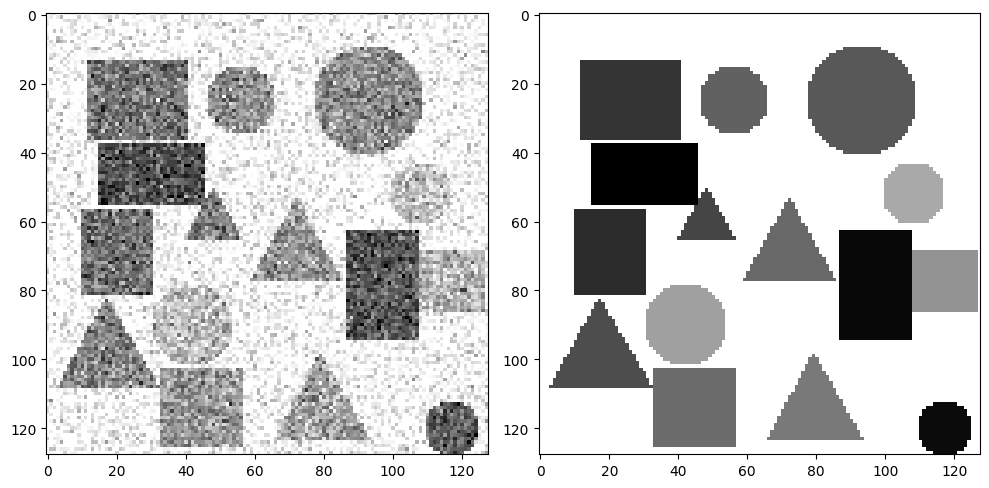

In [ ]:
# visualize one of the pair
vis_idx = 0

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(ns_img_train[vis_idx], cmap='gray')
plt.subplot(122)
plt.imshow(gt_img_train[vis_idx], cmap='gray')
plt.tight_layout()
plt.show(); plt.close()

In [ ]:
## function to create a CNN model
def cnn4dn_mdl(input_shape, layer_width=(8, 16, 8, 4)):
    inputs = Input(shape=input_shape)
    _tmp   = inputs
    for _lw in layer_width:
        _tmp = Conv2D(filters=_lw, kernel_size=3, padding='same', activation='relu')(_tmp)

    # output layer, 1 kernel/channel, no activation
    _out = Conv2D(filters=1, kernel_size=3, padding='same', activation=None)(_tmp)

    return tf.keras.models.Model(inputs, _out)

In [ ]:
tf.keras.backend.clear_session()
dn_mdl = cnn4dn_mdl(input_shape=(None, None, 1), layer_width=(8, 16, 8, 4))
dn_mdl.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 8)     80        
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    1168      
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 8)     1160      
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 4)     292       
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 1)     37        
                                                                 
Total params: 2737 (10.69 KB)
Trainable params: 2737 (10.69 K

In [ ]:
im = resize(im[:,:], (128, 128))

4/4 [==============================] - 0s 7ms/step


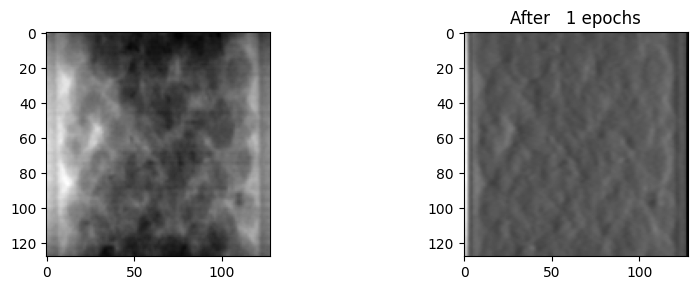

4/4 [==============================] - 0s 7ms/step


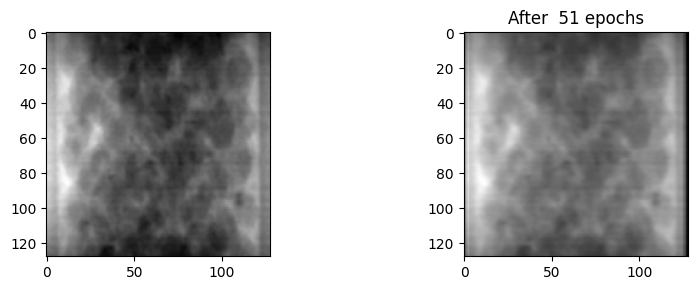

4/4 [==============================] - 0s 8ms/step


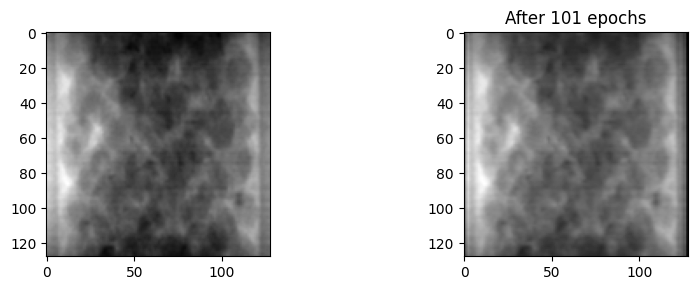

4/4 [==============================] - 0s 7ms/step


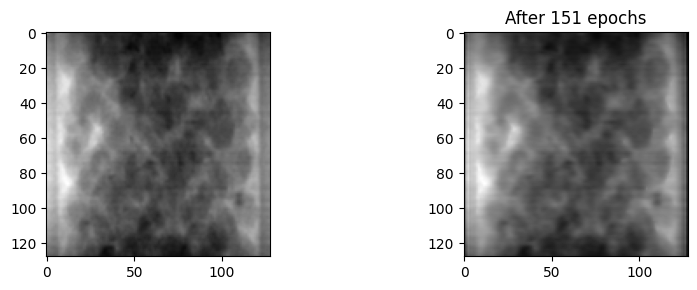

4/4 [==============================] - 0s 8ms/step


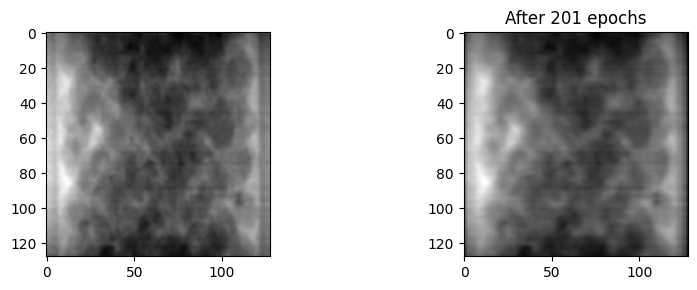

In [ ]:
## let's start from scratch building a loop to train the model iteratively, as shown in the figure

mbsz = 8 # mini batch size

mdl_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

for epoch in range(201): # Practice #2 play with max epoches
    # iterate over sample pairs batch by batch
    for _sidx in range(0, ns_img_train.shape[0]-mbsz, mbsz):

        # add an empty dimension to form 4D tensor
        mb_X = ns_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis]
        mb_y = gt_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis]

        with tf.GradientTape() as gd_tape:
            gd_tape.watch(dn_mdl.trainable_variables)

            dn_img = dn_mdl(mb_X, training=True) # try to denoise

            # compute the loss, use MSE here
            loss_mse = tf.losses.mean_squared_error(dn_img, mb_y)

            # compute the derivative of loss function of the model weights, i.e., gradient of weight
            gradients= gd_tape.gradient(loss_mse, dn_mdl.trainable_variables)

            # update neural network weights
            mdl_optimizer.apply_gradients(zip(gradients, dn_mdl.trainable_variables))

    if epoch % 50 != 0: continue # let's check how model performs after every 50 epochs
    if epoch == 0:
        val_X= im[:,:,np.newaxis]
        ns4vis = val_X.squeeze()
        #gt4vis = val_y.squeeze()
    dn_img_val = dn_mdl.predict(val_X).squeeze()

    plt.figure(figsize=(9, 3))
    plt.subplot(121)
    plt.imshow(ns4vis, cmap='gray')
    plt.subplot(122)
    #plt.imshow(gt4vis, cmap='gray')
    #plt.subplot(133)
    plt.imshow(dn_img_val, cmap='gray')
    plt.title('After %3d epochs' % (epoch+1))
    plt.tight_layout(); plt.show(); plt.close()


In [ ]:
im_norm = (im -  im.min())/(im.max()-im.min())
im_norm.mean()

0.39074332

In [ ]:
dn_img_resized = resize(dn_img_tomo[:,:], (128, 128))
print(dn_img_resized.shape)
dn_img_norm = (dn_img_resized - dn_img_resized.min())/(dn_img_resized.max()-dn_img_resized.min())


(128, 128)


In [ ]:
dn_img_val_norm =(dn_img_val - dn_img_val.min())/(dn_img_val.max()-dn_img_val.min())
dn_img_val_norm.max()

1.0

### Change achieved with TomoGAN

In [ ]:
diff_tomo = (abs(im_norm-dn_img_norm))
noise_tomo = diff_tomo.mean()
print("Average change with TomoGAN is ", noise_tomo)

Average change with TomoGAN is  0.11831439


### Image of removed noise (TomoGAN)

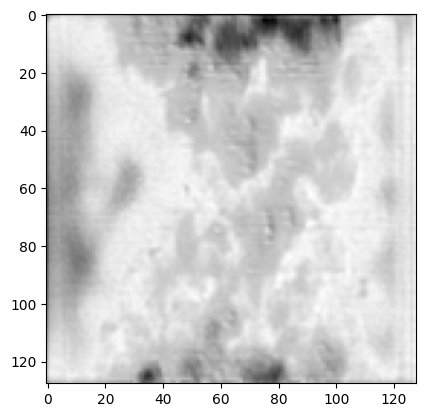

In [ ]:
plt.imshow((im_norm-dn_img_norm), cmap='gray')

### Image of denoised image (TomoGAN)

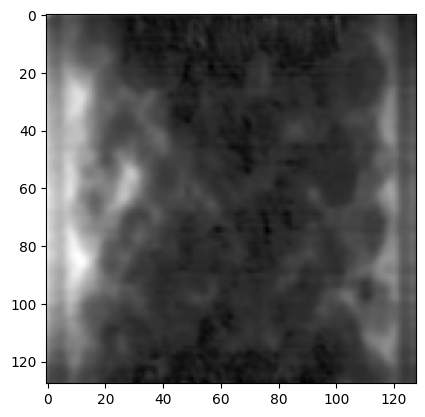

In [ ]:
plt.imshow((dn_img_norm*255).astype('float32'), cmap='gray')

### Change achieved with CNN

In [ ]:
diff_cnn = (abs(im_norm-dn_img_val_norm))
noise_cnn = diff_cnn.mean()
print("Average change with CNN is ", noise_cnn)


Average change with CNN is  0.018079996


### Image of removed noise (CNN)

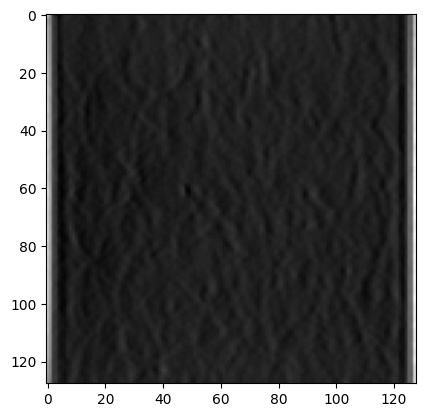

In [ ]:
plt.imshow((im_norm- dn_img_val_norm), cmap='gray')

### Image of denoised image (CNN)

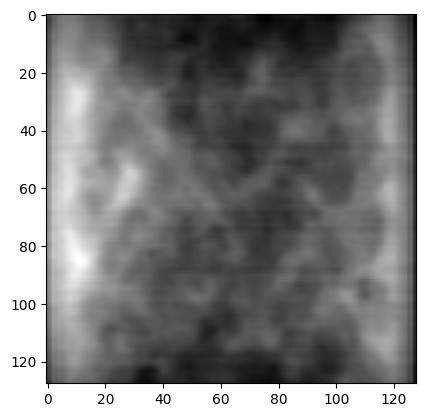

In [ ]:
plt.imshow((dn_img_val_norm*255).astype('float32'), cmap='gray')

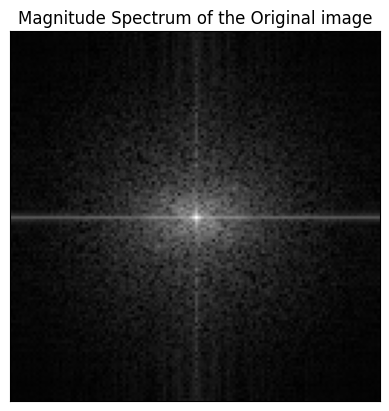

In [ ]:
f_transform = np.fft.fft2(im_norm)
f_transform_shifted = np.fft.fftshift(f_transform)
magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)

plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum of the Original image')
plt.xticks([]), plt.yticks([])
plt.show()

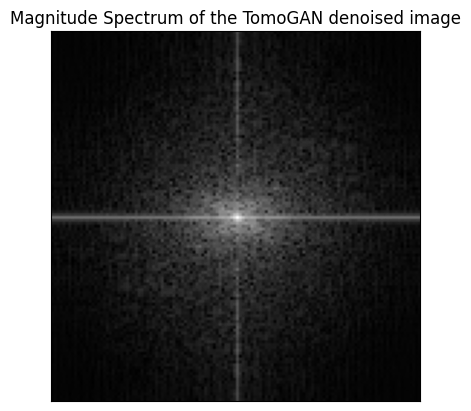

In [ ]:
f_transform = np.fft.fft2(dn_img_norm)
f_transform_shifted = np.fft.fftshift(f_transform)
magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)

plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum of the TomoGAN denoised image')
plt.xticks([]), plt.yticks([])
plt.show()

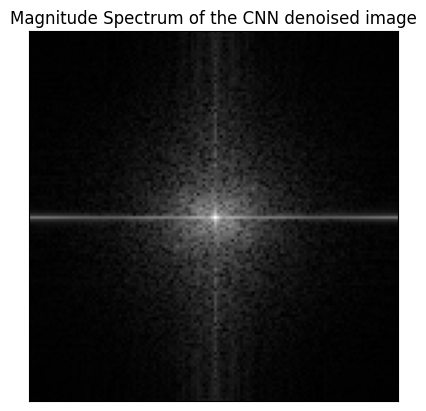

In [ ]:
f_transform = np.fft.fft2(dn_img_val_norm)
f_transform_shifted = np.fft.fftshift(f_transform)
magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)

plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum of the CNN denoised image')
plt.xticks([]), plt.yticks([])
plt.show()

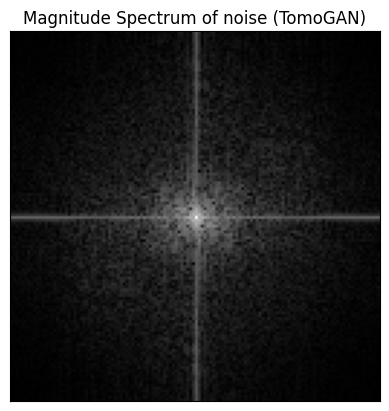

In [ ]:
f_transform = np.fft.fft2(im_norm-dn_img_norm)
f_transform_shifted = np.fft.fftshift(f_transform)
magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)
plt.title('Magnitude Spectrum of noise (TomoGAN)')
plt.imshow(magnitude_spectrum, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

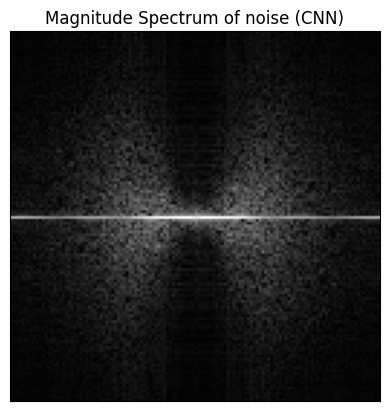

In [ ]:
f_transform = np.fft.fft2(im_norm-dn_img_val_norm)
f_transform_shifted = np.fft.fftshift(f_transform)
magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)
plt.title('Magnitude Spectrum of noise (CNN)')
plt.imshow(magnitude_spectrum, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
im_norm

array([[0.7016498 , 0.5197765 , 0.42928866, ..., 0.25627074, 0.2753475 ,
        0.28995064],
       [0.50301087, 0.45414212, 0.42389503, ..., 0.24495666, 0.2613205 ,
        0.26766843],
       [0.42907065, 0.42453977, 0.42039236, ..., 0.2443514 , 0.26182288,
        0.26627657],
       ...,
       [0.4435907 , 0.440364  , 0.43426177, ..., 0.38941485, 0.38688785,
        0.39376363],
       [0.41799286, 0.41246855, 0.40966868, ..., 0.3755443 , 0.38664067,
        0.39396632],
       [0.3918833 , 0.3764962 , 0.37497967, ..., 0.3562212 , 0.3671903 ,
        0.37904125]], dtype=float32)

### Adding Poissan noise:

In [ ]:
im_norm

array([[0.7016498 , 0.5197765 , 0.42928866, ..., 0.25627074, 0.2753475 ,
        0.28995064],
       [0.50301087, 0.45414212, 0.42389503, ..., 0.24495666, 0.2613205 ,
        0.26766843],
       [0.42907065, 0.42453977, 0.42039236, ..., 0.2443514 , 0.26182288,
        0.26627657],
       ...,
       [0.4435907 , 0.440364  , 0.43426177, ..., 0.38941485, 0.38688785,
        0.39376363],
       [0.41799286, 0.41246855, 0.40966868, ..., 0.3755443 , 0.38664067,
        0.39396632],
       [0.3918833 , 0.3764962 , 0.37497967, ..., 0.3562212 , 0.3671903 ,
        0.37904125]], dtype=float32)

In [ ]:
im

array([[6.4038982, 5.41768  , 4.927004 , ..., 3.988804 , 4.092249 ,
        4.1714354],
       [5.326767 , 5.0617733, 4.8977566, ..., 3.9274528, 4.0161867,
        4.0506086],
       [4.925822 , 4.9012527, 4.878763 , ..., 3.9241707, 4.018911 ,
        4.0430613],
       ...,
       [5.0045576, 4.9870605, 4.953971 , ..., 4.710786 , 4.697083 ,
        4.7343674],
       [4.8657517, 4.835796 , 4.8206134, ..., 4.635572 , 4.6957426,
        4.7354665],
       [4.724171 , 4.6407337, 4.63251  , ..., 4.5307913, 4.590272 ,
        4.6545343]], dtype=float32)

[[12.00389824 10.41767979  9.72700386 ...  7.9888041   8.09224892
   8.17143536]
 [11.12676697 10.8617733  10.29775658 ...  6.7274528   9.61618671
   6.65060863]
 [ 8.72582178 10.50125275  9.0787632  ...  7.72417073  7.81891088
   8.64306126]
 ...
 [ 9.80455761  9.38706055  9.35397091 ... 11.71078587 10.097083
  10.33436737]
 [ 9.26575174  9.03579588 10.82061338 ...  9.83557196  8.69574261
   8.53546648]
 [ 8.32417116  8.64073372  9.43251019 ...  8.53079128  9.99027195
   9.85453434]]


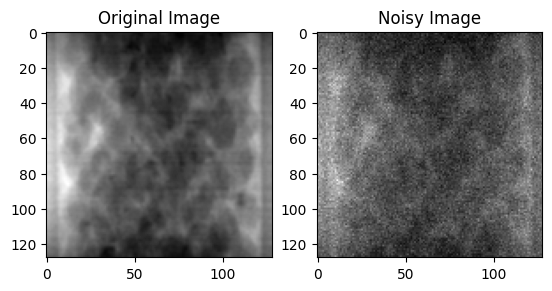

In [ ]:
intensity = 5
noisy_image = np.random.poisson(im * intensity) / intensity
noisy_image = im + noisy_image
print(noisy_image)
plt.subplot(121), plt.imshow(im, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(noisy_image, cmap='gray'), plt.title('Noisy Image')
plt.show()

In [ ]:
noisy_image_resized = resize(noisy_image[:,:], (2048, 2048))
noised=np.array([noisy_image_resized])
print(noised.shape)


(1, 2048, 2048)


In [ ]:
im_norm = (im - im.min())/(im.max()-im.min())
im_norm.shape

(128, 128)

In [ ]:
noise_image_resized_norm = (noisy_image_resized-noisy_image_resized.min())/(noisy_image_resized.max()-noisy_image_resized.min())
noise_image_resized_norm = resize(noise_image_resized_norm[:,:], (128, 128))

In [ ]:
im_norm.shape

(128, 128)

In [ ]:
print("Average pixel value difference by introducing Poissan noise is ", abs(im_norm-noise_image_resized_norm).mean())

Average pixel value difference by introducing Poissan noise is  0.06052579350656355


### Denoising Poisson with TomoGAN

In [ ]:
TomoGAN_mdl = tf.keras.models.load_model('TomoGAN.h5', )
TomoGAN_mdl.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 8)        16        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 32)       2336      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, None, None, 32)       9248      ['conv2d_1[0][0]']            
                                                                                              

1/1 [==============================] - 20s 20s/step


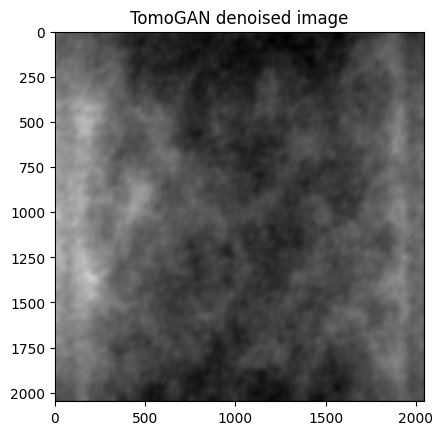

In [ ]:
for _idx in range(noised.shape[0]):
    dn_img_tomo_poissan = TomoGAN_mdl.predict(noised[_idx:_idx+1,:,:,np.newaxis]).squeeze()
    plt.imshow(dn_img_tomo_poissan, cmap='gray')
    plt.title('TomoGAN denoised image')

In [ ]:
dn_img_tomo_poissan

array([[11.853851 , 13.336038 , 13.714798 , ...,  8.267963 ,  8.628687 ,
         8.242374 ],
       [14.156815 , 13.574432 , 13.782602 , ...,  9.272655 ,  9.536833 ,
         9.53347  ],
       [14.599291 , 11.94742  , 13.796955 , ...,  8.513316 ,  8.9584055,
         8.308953 ],
       ...,
       [10.632587 ,  9.50568  ,  9.620481 , ...,  8.801174 ,  8.547737 ,
         8.211472 ],
       [10.061735 ,  9.123544 ,  9.504786 , ...,  8.136662 ,  8.347713 ,
         8.160927 ],
       [ 9.79875  ,  9.657226 , 10.685893 , ...,  8.619562 ,  8.324722 ,
         8.601719 ]], dtype=float32)

In [ ]:
poissan_denoised = resize(dn_img_tomo_poissan[:,:], (128, 128))
noisy_image = resize(noisy_image[:,:], (128, 128))


In [ ]:
poissan_norm =(poissan_denoised - poissan_denoised.min())/(poissan_denoised.max()-poissan_denoised.min())
noisy_image_norm =(noisy_image - noisy_image.min())/(noisy_image.max()- noisy_image.min())

In [ ]:
print("Average difference in pixel values between the original image and denoised image is ", abs(im_norm-poissan_norm).mean())
print("Average difference in pixel values between the poisson added image and denoised image is ", abs(noisy_image_norm-poissan_norm).mean())

Average difference in pixel values between the original image and denoised image is  0.024628535
Average difference in pixel values between the poisson added image and denoised image is  0.06298281293800517


### Denoising poisson noise with CNN

4/4 [==============================] - 0s 6ms/step


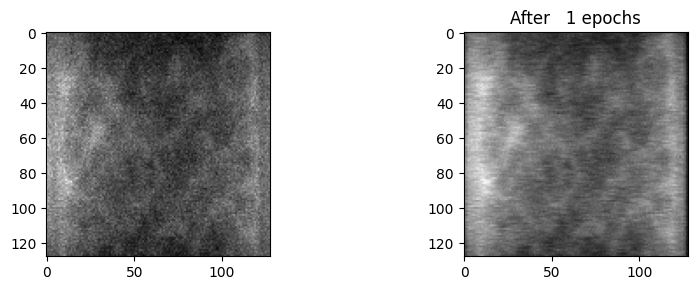

4/4 [==============================] - 0s 9ms/step


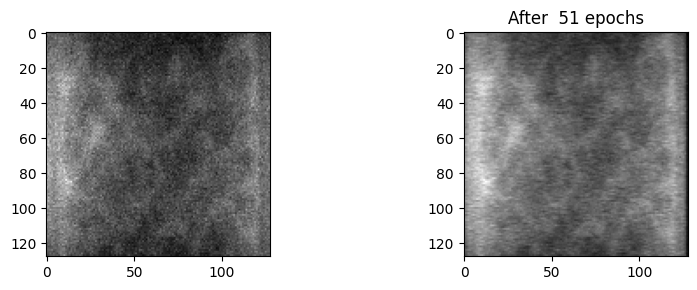

4/4 [==============================] - 0s 8ms/step


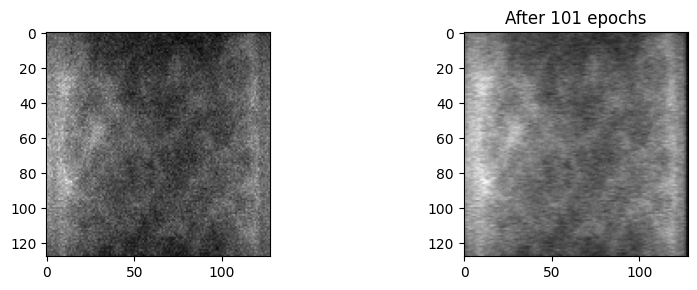

4/4 [==============================] - 0s 12ms/step


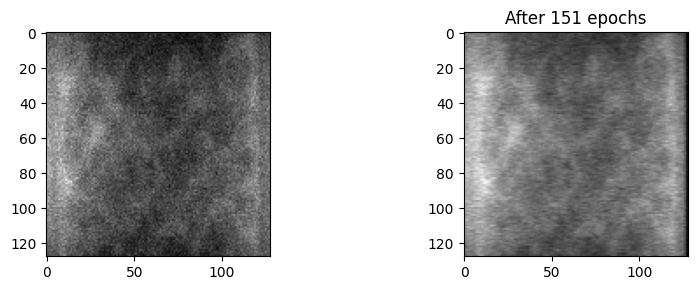

4/4 [==============================] - 0s 12ms/step


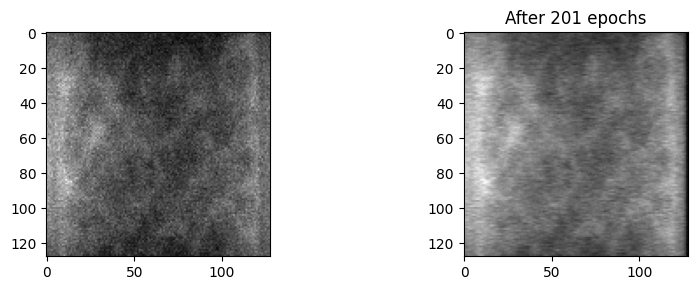

In [ ]:
## let's start from scratch building a loop to train the model iteratively, as shown in the figure

mbsz = 8 # mini batch size

mdl_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

for epoch in range(201): # Practice #2 play with max epoches
    # iterate over sample pairs batch by batch
    for _sidx in range(0, ns_img_train.shape[0]-mbsz, mbsz):

        # add an empty dimension to form 4D tensor
        mb_X = ns_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis]
        mb_y = gt_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis]

        with tf.GradientTape() as gd_tape:
            gd_tape.watch(dn_mdl.trainable_variables)

            dn_img = dn_mdl(mb_X, training=True) # try to denoise

            # compute the loss, use MSE here
            loss_mse = tf.losses.mean_squared_error(dn_img, mb_y)

            # compute the derivative of loss function of the model weights, i.e., gradient of weight
            gradients= gd_tape.gradient(loss_mse, dn_mdl.trainable_variables)

            # update neural network weights
            mdl_optimizer.apply_gradients(zip(gradients, dn_mdl.trainable_variables))

    if epoch % 50 != 0: continue # let's check how model performs after every 50 epochs
    if epoch == 0:
        val_X= noisy_image[:,:,np.newaxis]
        ns4vis = val_X.squeeze()
        #gt4vis = val_y.squeeze()
    dn_img_val_poissan = dn_mdl.predict(val_X).squeeze()

    plt.figure(figsize=(9, 3))
    plt.subplot(121)
    plt.imshow(ns4vis, cmap='gray')
    plt.subplot(122)
    #plt.imshow(gt4vis, cmap='gray')
    #plt.subplot(133)
    plt.imshow(dn_img_val_poissan, cmap='gray')
    plt.title('After %3d epochs' % (epoch+1))
    plt.tight_layout(); plt.show(); plt.close()


In [ ]:
dn_img_poissan_norm = (dn_img_val_poissan - dn_img_val_poissan.min())/(dn_img_val_poissan.max()-dn_img_val_poissan.min())
dn_img_poissan_norm.min()


0.0

In [ ]:
print("Average difference in pixel values between the original image and denoised image is ", abs(im_norm-dn_img_poissan_norm).mean())
print("Average difference in pixel values between the poisson added image and denoised image is ", abs(noisy_image_norm-dn_img_poissan_norm).mean())

Average difference in pixel values between the original image and denoised image is  0.09477906
Average difference in pixel values between the poisson added image and denoised image is  0.129055199993008
